In [96]:
# Imports
import tensorflow as tf
import numpy as np
import random
import pandas as pd

# Seed code
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

# Time-Series Forecasting on the S&P 500

In [97]:
df = pd.read_csv("yahoo_stock.csv")

Data Wrangling and Exploration

In [98]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

no null values

In [99]:
df.max()

Date           2020-11-20
High           3645.98999
Low           3600.159912
Open          3612.090088
Close         3626.909912
Volume       9044690000.0
Adj Close     3626.909912
dtype: object

In [100]:
df.min()

Date           2015-11-23
High               1847.0
Low           1810.099976
Open          1833.400024
Close         1829.079956
Volume       1296540000.0
Adj Close     1829.079956
dtype: object

In [101]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [102]:
df = df[['Date','Adj Close']]

In [103]:
df = df.sort_values('Date')

In [104]:
df = df.set_index('Date')

In [105]:
df

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107
...,...
2020-11-16,3626.909912
2020-11-17,3609.530029
2020-11-18,3567.790039


In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

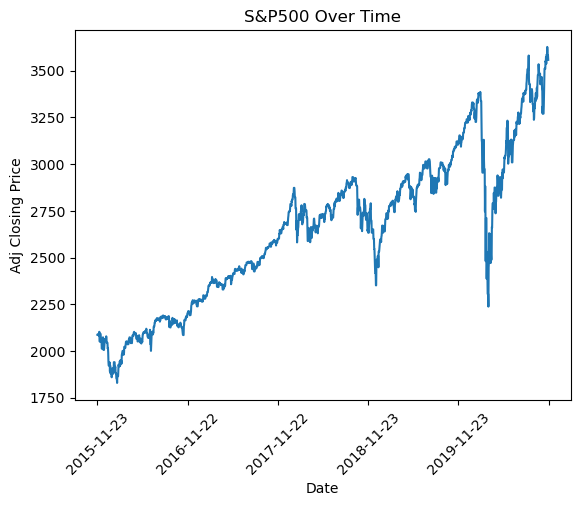

In [107]:
plt.plot(df)
plt.title("S&P500 Over Time")
plt.xlabel("Date")
plt.ylabel("Adj Closing Price")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

# Data Preprocessing

In [108]:
from sklearn.preprocessing import MinMaxScaler
train_df = df.iloc[0:int(len(df)*0.5),:]
validation_df = df.iloc[int(len(df)*0.5):int(len(df)*0.5)+int(len(df)*.25),:]
test_df = df.iloc[int(len(df)*0.5)+int(len(df)*.25): int(len(df)),:]
                   

In [109]:
print(f'train df: ',len(train_df))
print(f'validation df: ',len(validation_df))
print(f'test df: ',len(test_df))

train df:  912
validation df:  456
test df:  457


In [110]:
#Fitting Data
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [111]:
#Scale Data
train = pd.DataFrame(scaler.transform(train_df), columns=["Adj Close"], index= train_df.index)
validation = pd.DataFrame(scaler.transform(validation_df), columns=["Adj Close"], index= validation_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns=["Adj Close"], index= test_df.index)
                     

In [112]:
#Helper function to create window datasets
def create_dataset(dataset, window_size=1):
    data_x, data_y = [],[]
    for i in range(len(dataset)-window_size -1):
        window = dataset.iloc[i:(i+window_size),0]
        target = dataset.iloc[i+window_size,0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

In [113]:
window_size = 10

In [114]:
# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)


In [115]:
# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build and Train a Basic RNN Model

In [116]:
from tensorflow import keras
from tensorflow.keras import layers

In [117]:
#building the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(10, input_shape=(1,window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Now lets evaluate how good the model is!

In [118]:
# Import
from sklearn.metrics import r2_score

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1518   
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
-2.1148201684054473


r2 score was -53 which is terrible

# Building a LSTM Model

In [119]:
#Repeated but using LSTM instead of SimpleRNN
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, input_shape=(1,window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3258   
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
-53.49494907611489


this did not improve it as much as we thought

# Adding a Convolution Layer

In [121]:
#Repeated using LSTM but adding Convultional layer!
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(64, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(10, input_shape=(1,window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1, 64)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10)             │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,825 (14.94 KB)

 Trainable params: 3,825 (14.94 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2273   
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
-16.327974523995586


this was the best result so far.

# Optimizing the model

In [123]:
# Set the desired window size
window_size = 25

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=35)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(f"\nR-Squared value on validation set: {r2_score(y_validation, y_pred)}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 1, 128)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1946   
Epoch 2/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 
Epoch 3/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 
Epoch 4/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 
Epoch 5/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 6/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 7/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 
Epoch 8/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2174e-04 
Epoch 9/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7709e-04 
Epoch 10/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0466e-04 
Epoch 11/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0641e-04 
Epoch 12/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9107e-04 
Epoch 13/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6846e-04 
Epoch 14/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3983e-04 
Epoch 15/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

We increased window size from 10 to 25. Increased epochs to 35. R squared increased to 94%!

# Evaluating Model Performance

In [124]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.9942597380494432  --> Training Set
0.9419192559719836  --> Validation Set
0.9408000377788777  --> Test Set


In [91]:
# Un-window the training predictions
plot_train_pred = np.empty((len(df), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(df), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(df), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(df) - 1, :] = test_pred

In [125]:
print("Validation Predictions (scaled):", train_pred[:5])
train_pred_unscaled = scaler.inverse_transform(train_pred)
print("Validation Predictions (unscaled):", train_pred_unscaled[:5])


Validation Predictions (scaled): [[0.20771301]
 [0.17889336]
 [0.16052885]
 [0.16403635]
 [0.16909078]]
Validation Predictions (unscaled): [[2045.8887]
 [2015.807 ]
 [1996.6384]
 [2000.2996]
 [2005.5752]]


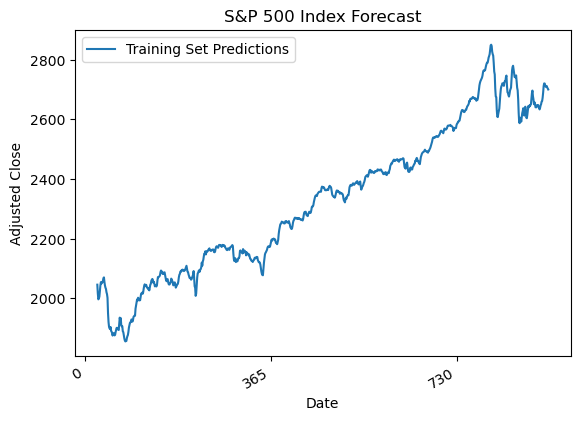

In [92]:
# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

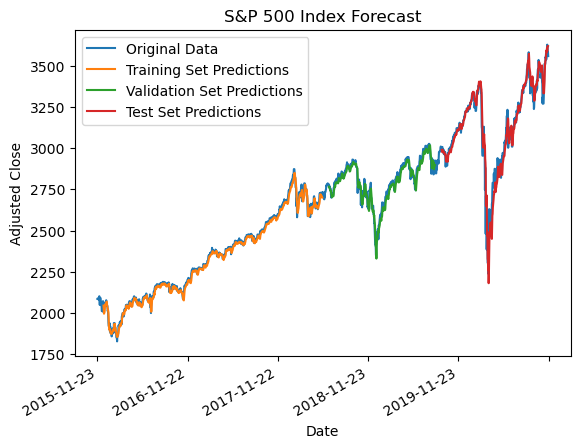

In [126]:
# Plot the original data
plt.plot(df, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()